In [ ]:
!git clone https://github.com/Trung-Nam-2512/analysis-heatmap.git
%cd analysis-heatmap

!pip install -r requirements.txt

!ls


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\heatmap\heatmap_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
# Đường dẫn file Excel
excel_file = '4_stations_31_7.xlsx'

# Kiểm tra file có tồn tại không
import os
if os.path.exists(excel_file):
    print(f"✅ File {excel_file} tồn tại!")
else:
    print(f"❌ File {excel_file} không tồn tại!")
    print("Hãy đảm bảo file Excel nằm trong cùng thư mục với notebook này.")
print("✅ Đã import thành công tất cả thư viện!")

✅ File 4_stations_31_7.xlsx tồn tại!
✅ Đã import thành công tất cả thư viện!


In [16]:
# Đọc thông tin các sheet trong file Excel
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

print(f"📊 Thông tin file Excel:")
print(f"• Tên file: {excel_file}")
print(f"• Số trạm: {len(sheet_names)}")
print(f"• Tên các trạm: {sheet_names}")

# Hiển thị thông tin từng sheet
for i, sheet in enumerate(sheet_names, 1):
    df_temp = pd.read_excel(excel_file, sheet_name=sheet)
    print(f"\n{i}. Trạm {sheet}:")
    print(f"   • Số dòng: {len(df_temp)}")
    print(f"   • Số cột: {len(df_temp.columns)}")
    print(f"   • Các cột: {list(df_temp.columns)}")

📊 Thông tin file Excel:
• Tên file: 4_stations_31_7.xlsx
• Số trạm: 4
• Tên các trạm: ['Bienhoa', 'Nhabe', 'Phuan', 'Thudaumot']

1. Trạm Bienhoa:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Year', 'Unnamed: 9', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Unnamed: 17', '>=1.6']

2. Trạm Nhabe:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Ups_discharge (Dautieng)', 'Unnamed: 9', 'Unnamed: 10', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Ups_discharge (Dautieng).1']

3. Trạm Phuan:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall(TSN)', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Ups_discharge (Dautieng)', 

In [17]:
# Định nghĩa các biến thủy văn cho từng trạm
station_variables = {
    'Bienhoa': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Nhabe': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Phuan': ['water level', 'rainfall(TSN)', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Thudaumot': ['water level', 'rainfall (Thuduc)', 'LSL', 'Built-up', 'Ups_discharge (Dautieng)']
}

print("📋 Định nghĩa biến thủy văn cho từng trạm:")
for station, vars_list in station_variables.items():
    print(f"\n🏢 {station}:")
    for i, var in enumerate(vars_list, 1):
        print(f"   {i}. {var}")

📋 Định nghĩa biến thủy văn cho từng trạm:

🏢 Bienhoa:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Nhabe:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Phuan:
   1. water level
   2. rainfall(TSN)
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Thudaumot:
   1. water level
   2. rainfall (Thuduc)
   3. LSL
   4. Built-up
   5. Ups_discharge (Dautieng)


In [18]:
# Dictionary để lưu dữ liệu annual max của từng trạm
annual_max_data = {}

print("🔄 Đang xử lý dữ liệu annual maximum cho từng trạm...")

for station in sheet_names:
    print(f"\n🏢 Xử lý trạm: {station}")
    
    # Load dữ liệu
    df = pd.read_excel(excel_file, sheet_name=station)
    
    # Tạo cột Year từ Times
    if 'Times' in df.columns:
        df['Year'] = df['Times'].dt.year
        print(f"   ✅ Đã tạo cột Year từ Times")
    else:
        print(f"   ❌ Không tìm thấy cột Times")
        continue
    
    # Lấy danh sách biến cần phân tích
    target_vars = station_variables.get(station, [])
    
    # Kiểm tra biến nào có trong dữ liệu
    available_vars = []
    for var in target_vars:
        if var in df.columns:
            available_vars.append(var)
            print(f"   ✅ Tìm thấy biến: {var}")
        else:
            print(f"   ❌ Không tìm thấy biến: {var}")
    
    if len(available_vars) == 0:
        print(f"   ❌ Không có biến nào khả dụng cho trạm {station}")
        continue
    
    # Tính annual maximum
    annual_max = df.groupby('Year')[available_vars].max()
    
    # Loại bỏ dòng có NaN
    annual_max_clean = annual_max.dropna()
    
    print(f"   📊 Kết quả annual maximum:")
    print(f"      • Số năm gốc: {len(annual_max)}")
    print(f"      • Số năm sau khi loại NaN: {len(annual_max_clean)}")
    print(f"      • Năm bắt đầu: {annual_max_clean.index.min()}")
    print(f"      • Năm kết thúc: {annual_max_clean.index.max()}")
    
    # Lưu vào dictionary
    annual_max_data[station] = {
        'data': annual_max_clean,
        'variables': available_vars,
        'years': len(annual_max_clean)
    }

print(f"\n✅ Hoàn thành xử lý dữ liệu annual maximum cho {len(annual_max_data)} trạm!")

🔄 Đang xử lý dữ liệu annual maximum cho từng trạm...

🏢 Xử lý trạm: Bienhoa
   ✅ Đã tạo cột Year từ Times
   ✅ Tìm thấy biến: water level
   ✅ Tìm thấy biến: rainfall
   ✅ Tìm thấy biến: LSL
   ✅ Tìm thấy biến: Built-up
   ✅ Tìm thấy biến: Ups_discharge (Trian)
   📊 Kết quả annual maximum:
      • Số năm gốc: 34
      • Số năm sau khi loại NaN: 34
      • Năm bắt đầu: 1981
      • Năm kết thúc: 2014

🏢 Xử lý trạm: Nhabe
   ✅ Đã tạo cột Year từ Times
   ✅ Tìm thấy biến: water level
   ✅ Tìm thấy biến: rainfall
   ✅ Tìm thấy biến: LSL
   ✅ Tìm thấy biến: Built-up
   ✅ Tìm thấy biến: Ups_discharge (Trian)
   📊 Kết quả annual maximum:
      • Số năm gốc: 34
      • Số năm sau khi loại NaN: 34
      • Năm bắt đầu: 1981
      • Năm kết thúc: 2014

🏢 Xử lý trạm: Phuan
   ✅ Đã tạo cột Year từ Times
   ✅ Tìm thấy biến: water level
   ✅ Tìm thấy biến: rainfall(TSN)
   ✅ Tìm thấy biến: LSL
   ✅ Tìm thấy biến: Built-up
   ✅ Tìm thấy biến: Ups_discharge (Trian)
   📊 Kết quả annual maximum:
      • 

📊 Tạo correlation heatmap cho annual maximum...

🏢 Trạm: Bienhoa
   ✅ Đã lưu: correlation_heatmap_Bienhoa.png


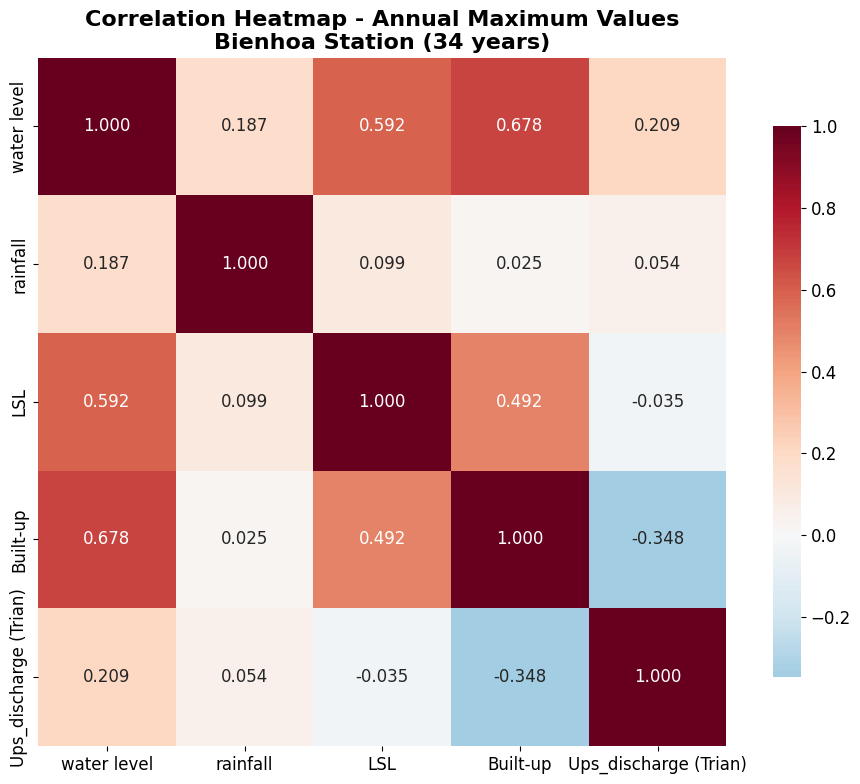

   📊 Thống kê correlation:
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
      • Số cặp có |correlation| > 0.5: 4

🏢 Trạm: Nhabe
   ✅ Đã lưu: correlation_heatmap_Nhabe.png


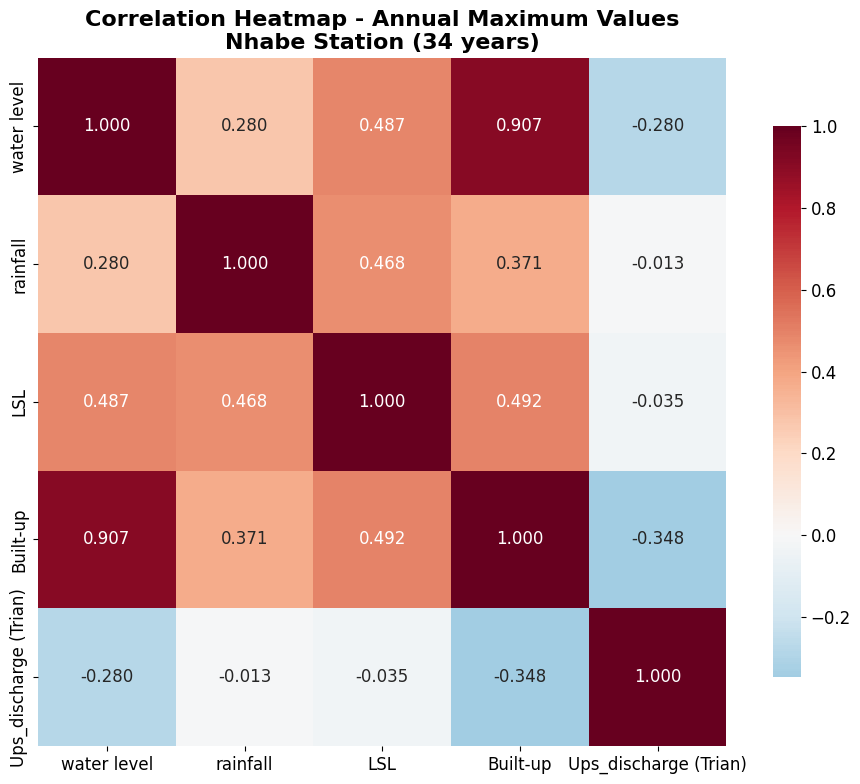

   📊 Thống kê correlation:
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
      • Số cặp có |correlation| > 0.5: 2

🏢 Trạm: Phuan
   ✅ Đã lưu: correlation_heatmap_Phuan.png


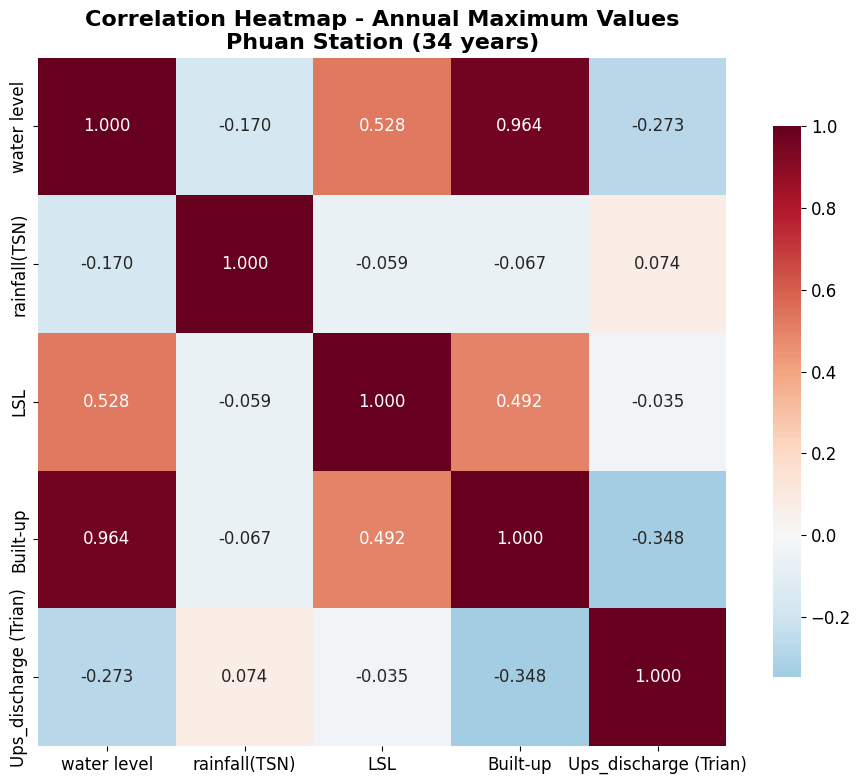

   📊 Thống kê correlation:
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
      • Số cặp có |correlation| > 0.5: 4

🏢 Trạm: Thudaumot
   ✅ Đã lưu: correlation_heatmap_Thudaumot.png


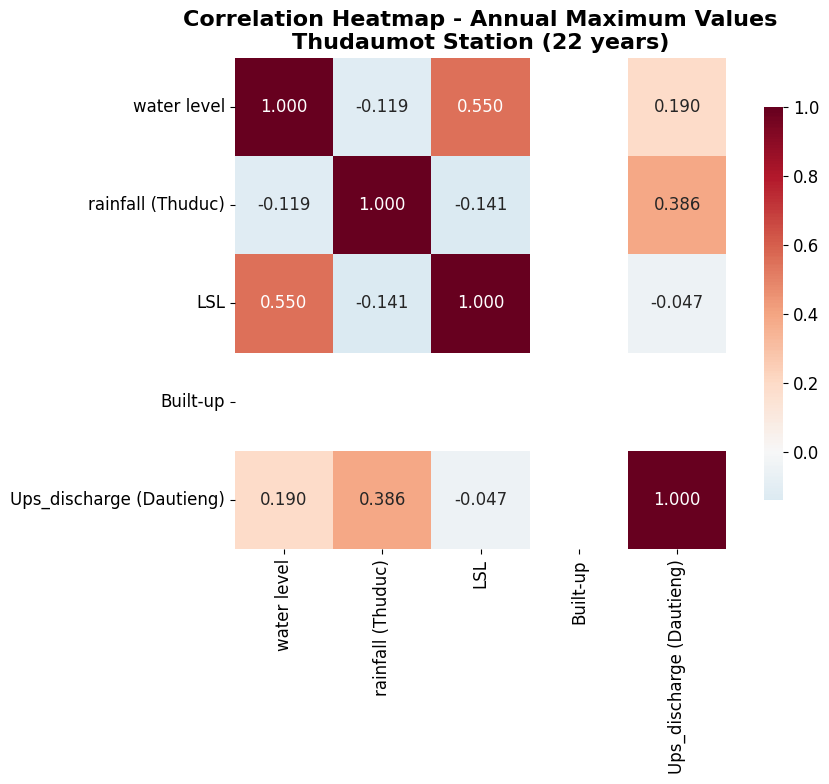

   📊 Thống kê correlation:
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.141
      • Số cặp có |correlation| > 0.5: 1


In [19]:
# Tạo correlation heatmap cho từng trạm
print("📊 Tạo correlation heatmap cho annual maximum...")

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    
    data = station_info['data']
    variables = station_info['variables']
    
    # Tính correlation matrix
    corr_matrix = data.corr()
    
    # Tạo heatmap - HIỂN THỊ ĐẦY ĐỦ (không dùng mask)
    plt.figure(figsize=(10, 8))
    
    # Vẽ heatmap đầy đủ
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title(f'Correlation Heatmap - Annual Maximum Values\n{station} Station ({station_info["years"]} years)', 
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu biểu đồ
    filename = f'correlation_heatmap_{station}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"   ✅ Đã lưu: {filename}")
    
    plt.show()
    
    # Hiển thị thống kê correlation
    print(f"   📊 Thống kê correlation:")
    print(f"      • Correlation cao nhất: {corr_matrix.max().max():.3f}")
    print(f"      • Correlation thấp nhất: {corr_matrix.min().min():.3f}")
    print(f"      • Số cặp có |correlation| > 0.5: {(abs(corr_matrix) > 0.5).sum().sum() - len(variables)}")

In [20]:
# Hàm tính lagged correlation
def calculate_lagged_correlation(data, var1, var2, lag):
    """
    Tính correlation giữa var1 và var2 với độ trễ lag
    lag > 0: var2 trễ so với var1
    lag < 0: var1 trễ so với var2
    """
    if lag == 0:
        # Không có lag
        series1 = data[var1].dropna()
        series2 = data[var2].dropna()
    elif lag > 0:
        # var2 trễ so với var1
        series1 = data[var1].iloc[:-lag].dropna()
        series2 = data[var2].iloc[lag:].dropna()
    else:
        # var1 trễ so với var2
        series1 = data[var1].iloc[-lag:].dropna()
        series2 = data[var2].iloc[:lag].dropna()
    
    # Đảm bảo hai series có cùng độ dài
    min_len = min(len(series1), len(series2))
    if min_len < 3:  # Cần ít nhất 3 điểm để tính correlation
        return np.nan, np.nan
    
    series1 = series1.iloc[:min_len]
    series2 = series2.iloc[:min_len]
    
    try:
        corr, p_value = stats.pearsonr(series1, series2)
        return corr, p_value
    except:
        return np.nan, np.nan

print("✅ Đã định nghĩa hàm calculate_lagged_correlation")

✅ Đã định nghĩa hàm calculate_lagged_correlation


⏰ Tạo lagged correlation heatmap...

🏢 Trạm: Bienhoa
   ✅ Đã lưu: lagged_correlation_heatmap_Bienhoa.png


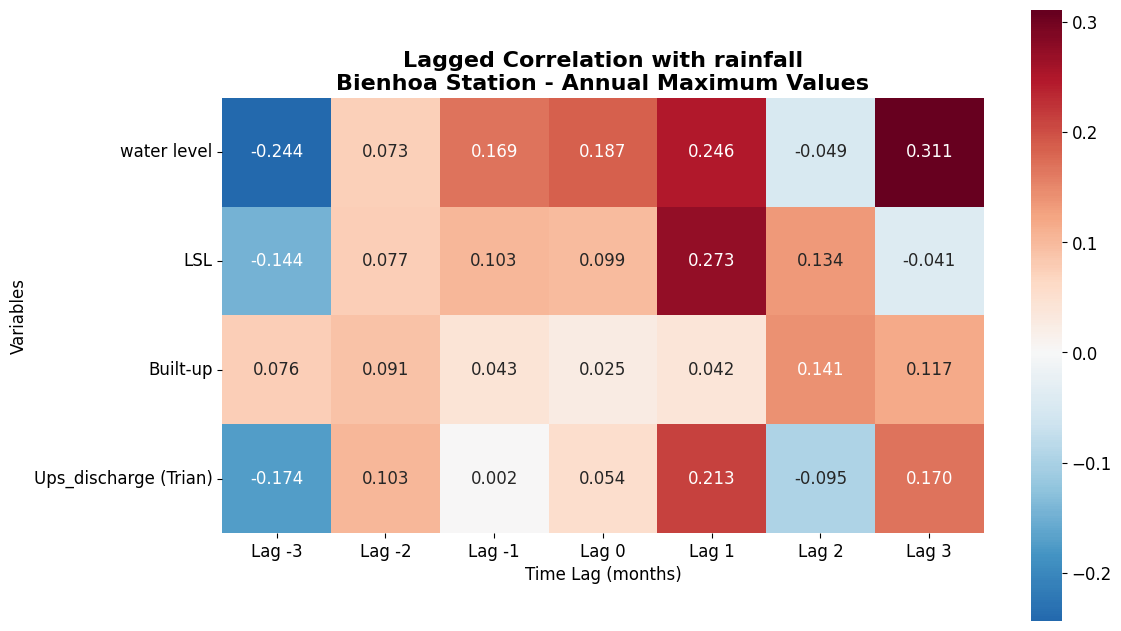

   📊 Thống kê lagged correlation:
      • Correlation cao nhất: 0.311
      • Correlation thấp nhất: -0.244
      • Số cặp có |correlation| > 0.5: 0

🏢 Trạm: Nhabe
   ✅ Đã lưu: lagged_correlation_heatmap_Nhabe.png


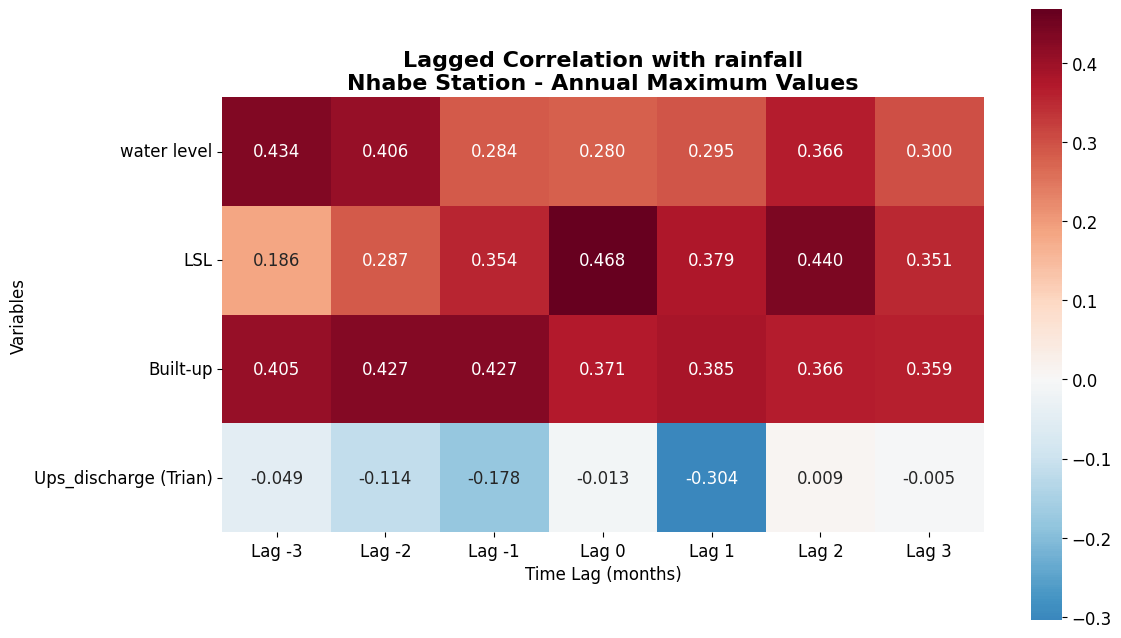

   📊 Thống kê lagged correlation:
      • Correlation cao nhất: 0.468
      • Correlation thấp nhất: -0.304
      • Số cặp có |correlation| > 0.5: 0

🏢 Trạm: Phuan
   ✅ Đã lưu: lagged_correlation_heatmap_Phuan.png


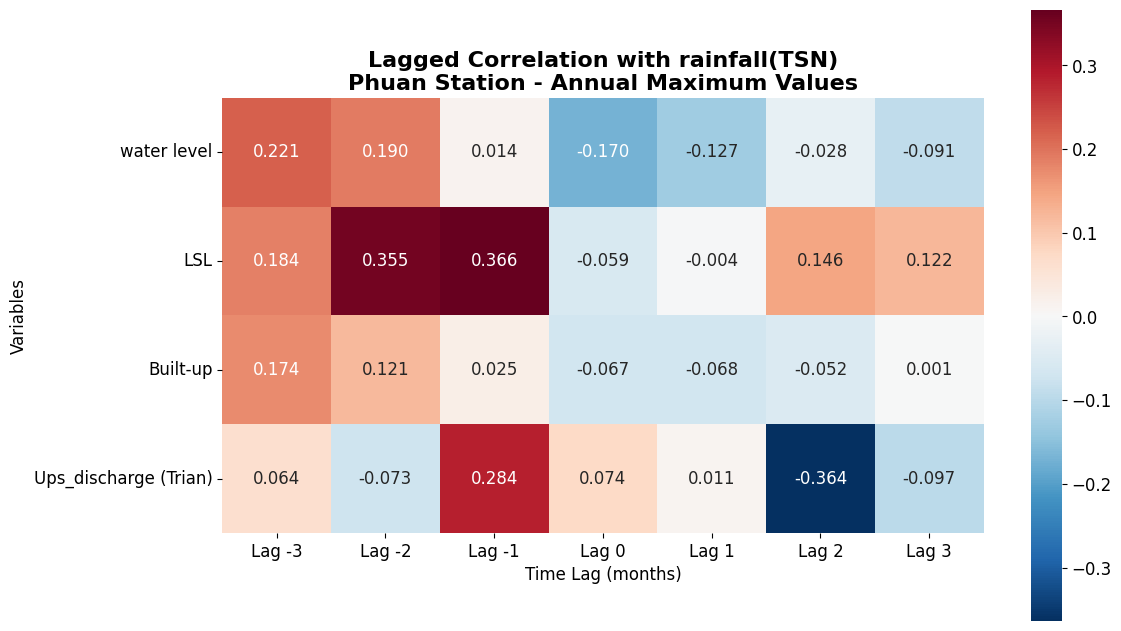

   📊 Thống kê lagged correlation:
      • Correlation cao nhất: 0.366
      • Correlation thấp nhất: -0.364
      • Số cặp có |correlation| > 0.5: 0

🏢 Trạm: Thudaumot
   ✅ Đã lưu: lagged_correlation_heatmap_Thudaumot.png


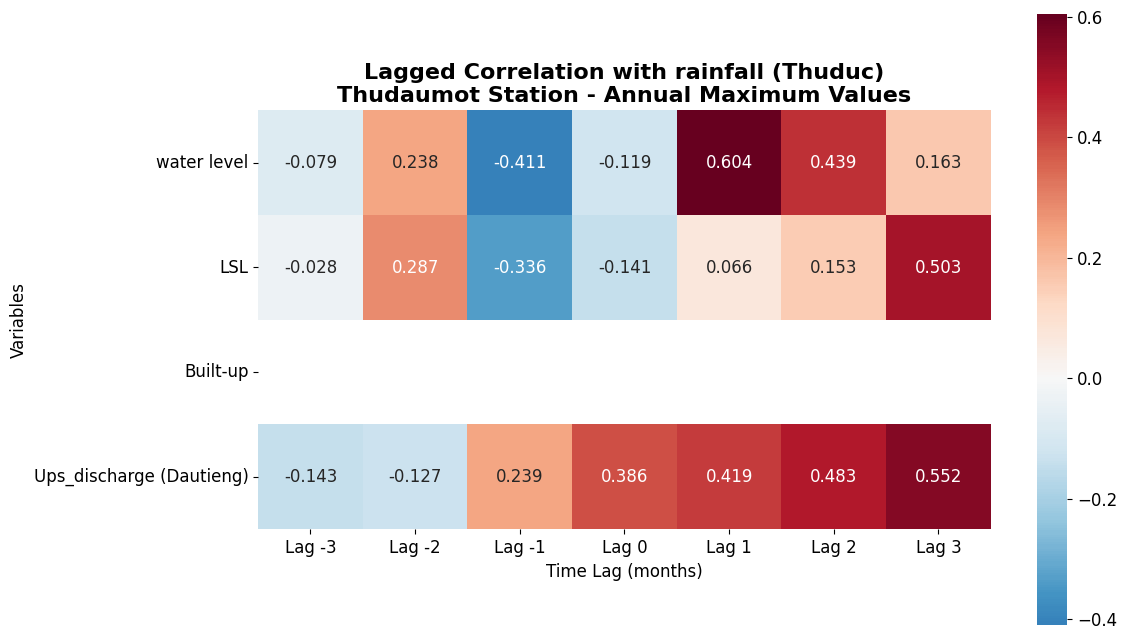

   📊 Thống kê lagged correlation:
      • Correlation cao nhất: 0.604
      • Correlation thấp nhất: -0.411
      • Số cặp có |correlation| > 0.5: 3


In [21]:
# Tạo lagged correlation heatmap cho từng trạm
print("⏰ Tạo lagged correlation heatmap...")

lags = range(-3, 4)  # Từ -3 đến +3 tháng

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    
    data = station_info['data']
    variables = station_info['variables']
    
    # Tìm biến rainfall
    rainfall_var = None
    for var in variables:
        if 'rainfall' in var.lower():
            rainfall_var = var
            break
    
    if rainfall_var is None:
        print(f"   ❌ Không tìm thấy biến rainfall trong {station}")
        continue
    
    # Tạo matrix cho correlation và p-value
    corr_matrix = []
    p_matrix = []
    
    # Tính correlation với rainfall cho từng biến khác
    for var1 in variables:
        if var1 == rainfall_var:
            continue  # Bỏ qua rainfall với chính nó
        
        row_corr = []
        row_p = []
        
        for lag in lags:
            corr, p_val = calculate_lagged_correlation(data, var1, rainfall_var, lag)
            row_corr.append(corr)
            row_p.append(p_val)
        
        corr_matrix.append(row_corr)
        p_matrix.append(row_p)
    
    # Chuyển thành DataFrame
    corr_df = pd.DataFrame(corr_matrix, 
                          index=[var for var in variables if var != rainfall_var],
                          columns=[f'Lag {lag}' for lag in lags])
    
    p_df = pd.DataFrame(p_matrix,
                       index=[var for var in variables if var != rainfall_var],
                       columns=[f'Lag {lag}' for lag in lags])
    
    # Tạo heatmap
    plt.figure(figsize=(12, 8))
    
    # Vẽ heatmap đầy đủ
    sns.heatmap(corr_df, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title(f'Lagged Correlation with {rainfall_var}\n{station} Station - Annual Maximum Values', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Time Lag (months)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.tight_layout()
    
    # Lưu biểu đồ
    filename = f'lagged_correlation_heatmap_{station}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"   ✅ Đã lưu: {filename}")
    
    plt.show()
    
    # Hiển thị thống kê
    print(f"   📊 Thống kê lagged correlation:")
    print(f"      • Correlation cao nhất: {corr_df.max().max():.3f}")
    print(f"      • Correlation thấp nhất: {corr_df.min().min():.3f}")
    print(f"      • Số cặp có |correlation| > 0.5: {(abs(corr_df) > 0.5).sum().sum()}")

📅 Phân tích theo giai đoạn thời gian...

🏢 Trạm: Bienhoa
   ✅ Đã lưu: time_period_analysis_Bienhoa.png


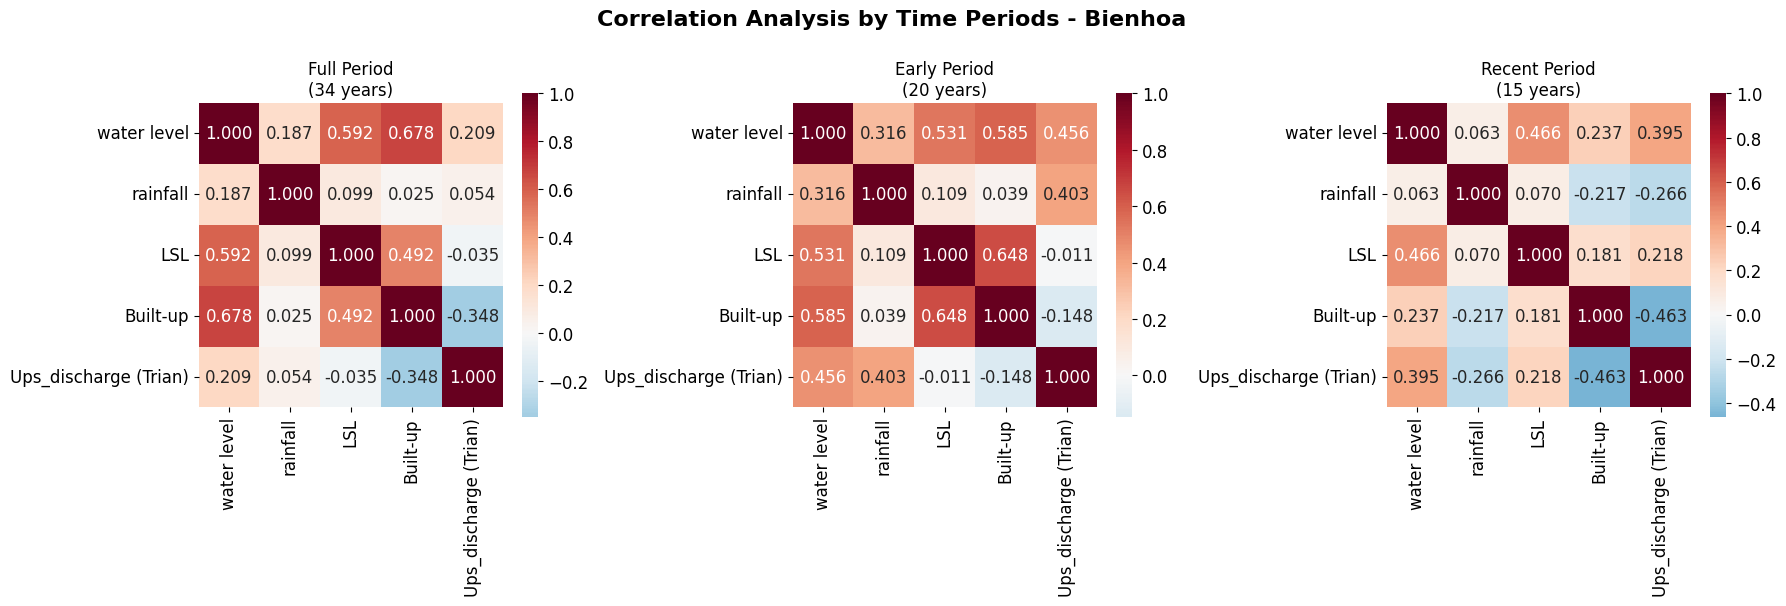

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Nhabe
   ✅ Đã lưu: time_period_analysis_Nhabe.png


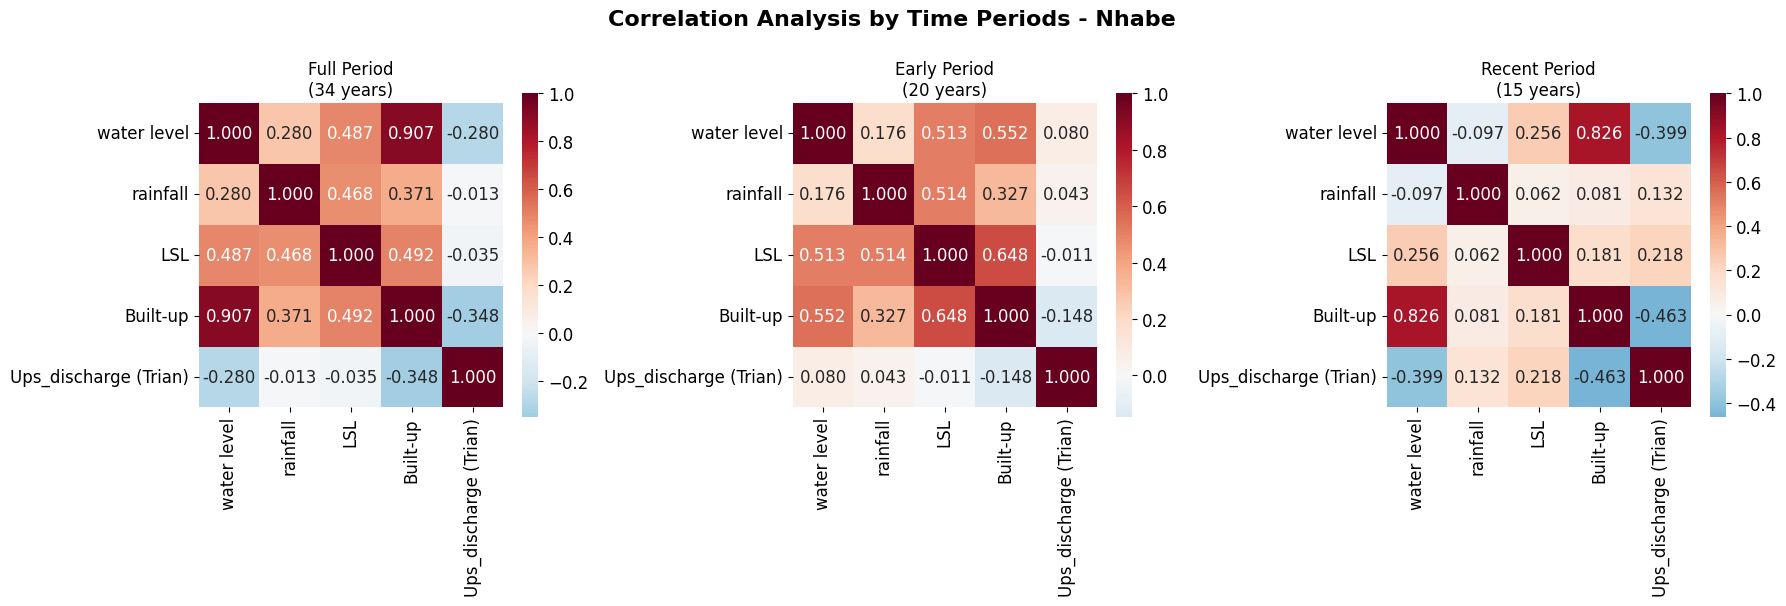

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Phuan
   ✅ Đã lưu: time_period_analysis_Phuan.png


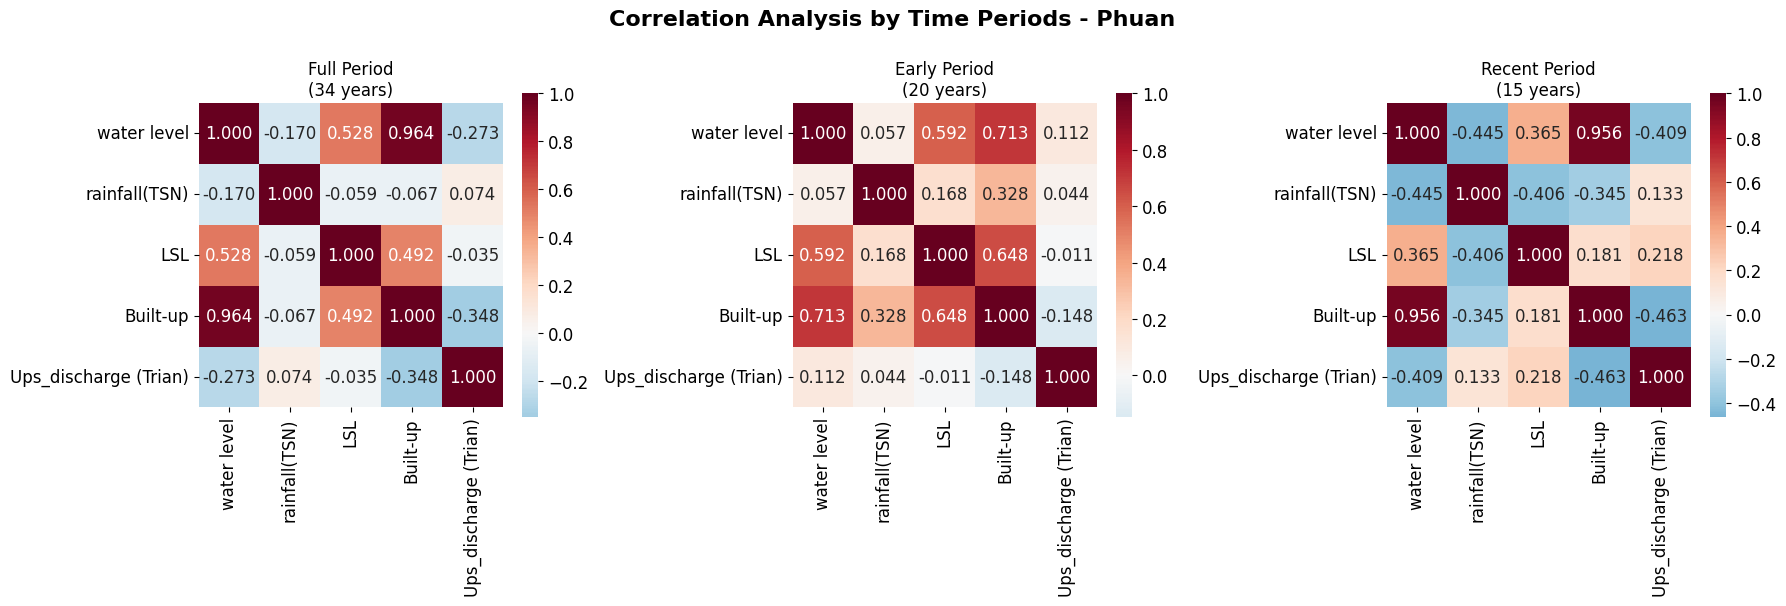

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Thudaumot
   ✅ Đã lưu: time_period_analysis_Thudaumot.png


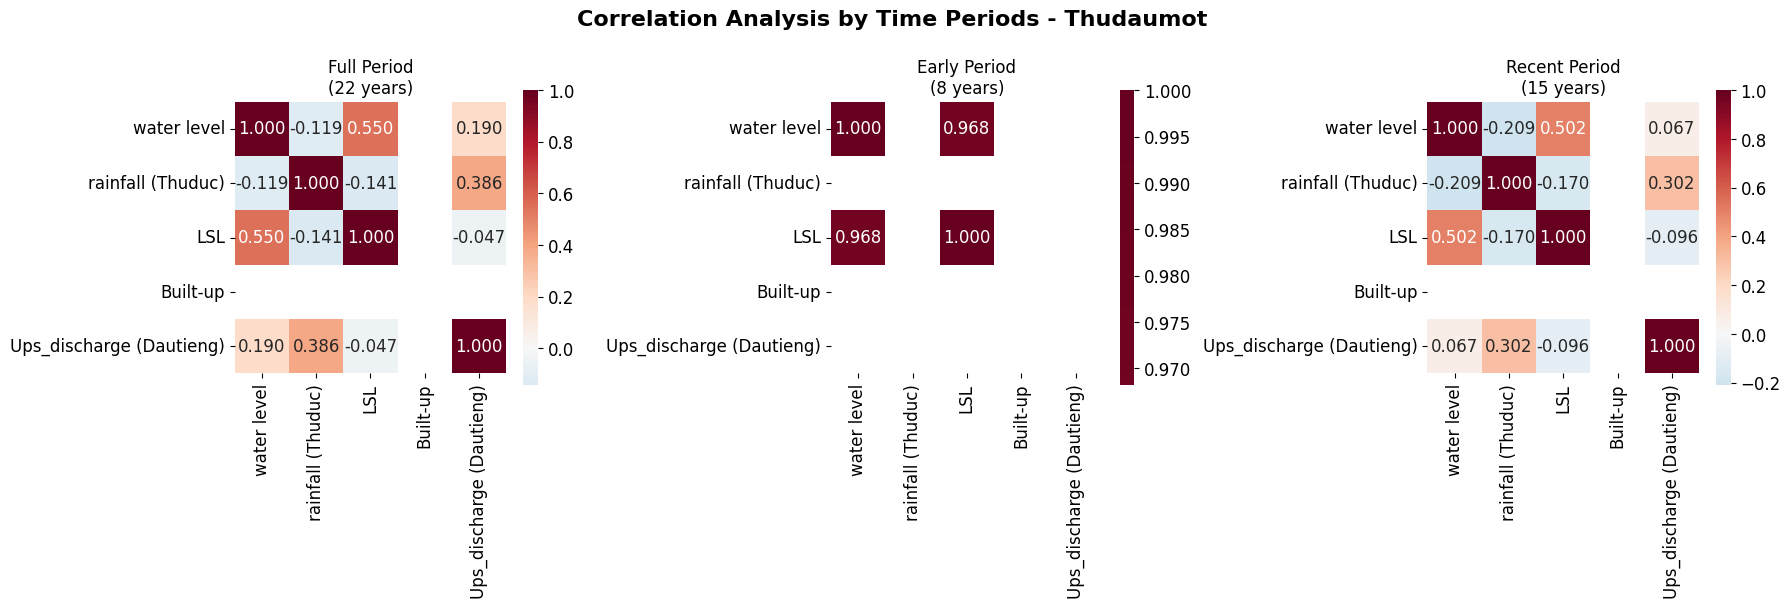

   📊 Full Period (22 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.141
   📊 Early Period (8 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: 0.968
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.209


In [22]:
# Phân tích theo giai đoạn thời gian
print("📅 Phân tích theo giai đoạn thời gian...")

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    
    data = station_info['data']
    variables = station_info['variables']
    
    # Chia thành các giai đoạn
    periods = {
        'Full Period': data,
        'Early Period': data[data.index <= 2000],
        'Recent Period': data[data.index >= 2000]
    }
    
    # Tạo subplot cho từng giai đoạn
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Correlation Analysis by Time Periods - {station}', fontsize=16, fontweight='bold')
    
    for i, (period_name, period_data) in enumerate(periods.items()):
        if len(period_data) < 3:
            print(f"   ⚠️ Giai đoạn {period_name} có ít dữ liệu ({len(period_data)} năm)")
            continue
        
        # Tính correlation
        corr_matrix = period_data.corr()
        
        # Vẽ heatmap đầy đủ
        sns.heatmap(corr_matrix, 
                    annot=True, 
                    cmap='RdBu_r', 
                    center=0,
                    square=True,
                    fmt='.3f',
                    ax=axes[i],
                    cbar_kws={"shrink": .8})
        
        axes[i].set_title(f'{period_name}\n({len(period_data)} years)', fontsize=12)
    
    plt.tight_layout()
    
    # Lưu biểu đồ
    filename = f'time_period_analysis_{station}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"   ✅ Đã lưu: {filename}")
    
    plt.show()
    
    # Hiển thị thống kê từng giai đoạn
    for period_name, period_data in periods.items():
        if len(period_data) >= 3:
            corr_matrix = period_data.corr()
            print(f"   📊 {period_name} ({len(period_data)} years):")
            print(f"      • Correlation cao nhất: {corr_matrix.max().max():.3f}")
            print(f"      • Correlation thấp nhất: {corr_matrix.min().min():.3f}")

🎯 Tạo biểu đồ tổng hợp...
📋 Biến chung: ['Built-up', 'LSL', 'water level']
✅ Đã lưu: combined_correlation_heatmap.png


<Figure size 1200x1000 with 0 Axes>

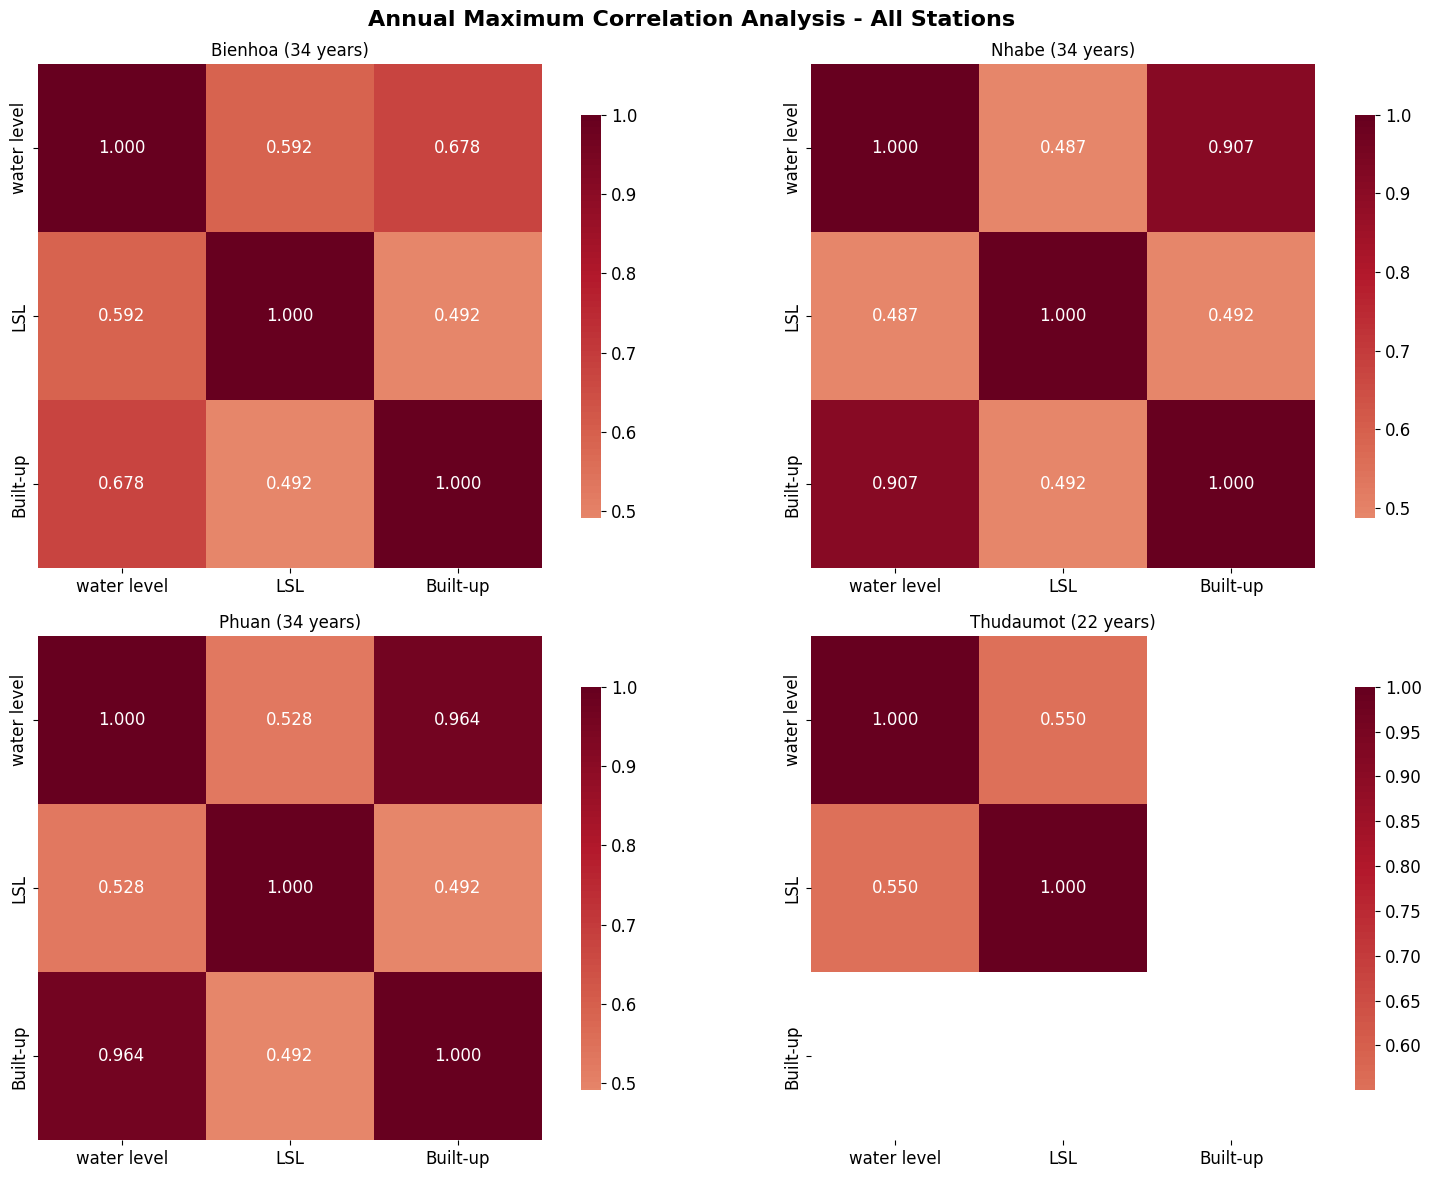

In [23]:
# Tạo biểu đồ tổng hợp cho tất cả trạm
print("🎯 Tạo biểu đồ tổng hợp...")

# Gộp dữ liệu từ tất cả trạm
all_data = []
for station, station_info in annual_max_data.items():
    data = station_info['data'].copy()
    data['Station'] = station
    all_data.append(data)

if all_data:
    combined_data = pd.concat(all_data, ignore_index=False)
    
    # Tìm biến chung
    common_vars = set.intersection(*[set(station_info['variables']) for station_info in annual_max_data.values()])
    
    if len(common_vars) >= 2:
        print(f"📋 Biến chung: {list(common_vars)}")
        
        # Tạo correlation heatmap tổng hợp
        plt.figure(figsize=(12, 10))
        
        # Tính correlation cho từng trạm
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Annual Maximum Correlation Analysis - All Stations', fontsize=16, fontweight='bold')
        
        for i, (station, station_info) in enumerate(annual_max_data.items()):
            row = i // 2
            col = i % 2
            
            data = station_info['data']
            variables = station_info['variables']
            
            # Chỉ lấy biến chung
            common_vars_station = [var for var in variables if var in common_vars]
            if len(common_vars_station) >= 2:
                corr_matrix = data[common_vars_station].corr()
                
                # Vẽ heatmap đầy đủ
                sns.heatmap(corr_matrix, 
                            annot=True, 
                            cmap='RdBu_r', 
                            center=0,
                            square=True,
                            fmt='.3f',
                            ax=axes[row, col],
                            cbar_kws={"shrink": .8})
                
                axes[row, col].set_title(f'{station} ({station_info["years"]} years)', fontsize=12)
        
        plt.tight_layout()
        
        # Lưu biểu đồ
        filename = 'combined_correlation_heatmap.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Đã lưu: {filename}")
        
        plt.show()
    else:
        print("⚠️ Không đủ biến chung để tạo biểu đồ tổng hợp")

In [24]:
# Tóm tắt kết quả phân tích
print("📊 TÓM TẮT KẾT QUẢ PHÂN TÍCH")
print("=" * 80)

print(f"\n📁 THÔNG TIN DỮ LIỆU:")
print(f"• File Excel: {excel_file}")
print(f"• Số trạm đã phân tích: {len(annual_max_data)}")

print(f"\n🏢 CHI TIẾT TỪNG TRẠM:")
for station, station_info in annual_max_data.items():
    print(f"\n• {station}:")
    print(f"  - Số năm dữ liệu: {station_info['years']}")
    print(f"  - Số biến thủy văn: {len(station_info['variables'])}")
    print(f"  - Các biến: {station_info['variables']}")

📊 TÓM TẮT KẾT QUẢ PHÂN TÍCH

📁 THÔNG TIN DỮ LIỆU:
• File Excel: 4_stations_31_7.xlsx
• Số trạm đã phân tích: 4

🏢 CHI TIẾT TỪNG TRẠM:

• Bienhoa:
  - Số năm dữ liệu: 34
  - Số biến thủy văn: 5
  - Các biến: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']

• Nhabe:
  - Số năm dữ liệu: 34
  - Số biến thủy văn: 5
  - Các biến: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']

• Phuan:
  - Số năm dữ liệu: 34
  - Số biến thủy văn: 5
  - Các biến: ['water level', 'rainfall(TSN)', 'LSL', 'Built-up', 'Ups_discharge (Trian)']

• Thudaumot:
  - Số năm dữ liệu: 22
  - Số biến thủy văn: 5
  - Các biến: ['water level', 'rainfall (Thuduc)', 'LSL', 'Built-up', 'Ups_discharge (Dautieng)']
